In [2]:
!pip install opencv-contrib-python --upgrade
!pip install facenet-pytorch --upgrade

In [3]:
from facenet_pytorch import MTCNN, InceptionResnetV1
from PIL import Image, ImageDraw
import torch
import cv2
import numpy as np
from typing import Tuple
import glob

from IPython.display import display

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# crop and pad image
def resize_with_pad(image: np.array, 
                    new_shape: Tuple[int, int], 
                    padding_color: Tuple[int] = (255, 255, 255)) -> np.array:
    """Maintains aspect ratio and resizes with padding.
    Params:
        image: Image to be resized.
        new_shape: Expected (width, height) of new image.
        padding_color: Tuple in BGR of padding color
    Returns:
        image: Resized image with padding
    """
    original_shape = (image.shape[1], image.shape[0])
    ratio = float(max(new_shape))/max(original_shape)
    new_size = tuple([int(x*ratio) for x in original_shape])
    image = cv2.resize(image, new_size)
    delta_w = new_shape[0] - new_size[0]
    delta_h = new_shape[1] - new_size[1]
    top, bottom = delta_h//2, delta_h-(delta_h//2)
    left, right = delta_w//2, delta_w-(delta_w//2)
    image = cv2.copyMakeBorder(image, top, bottom, left, right, cv2.BORDER_CONSTANT, value=padding_color)
    return image

In [47]:
def crop_largest_face(image_file, device, shape=(512, 512)):
     
    img = Image.open(image_file)
    
    # face detection
    mtcnn = MTCNN(
        image_size=160, margin=0, min_face_size=20,
        thresholds=[0.6, 0.7, 0.7], factor=0.709, post_process=True,
        device=device
    )
    boxes, _ = mtcnn.detect(img)
    
    image_array = np.array(img) 
    
    largest_index = 0
    largest_face = 0

    width = 0
    height = 0

    # find largest face
    for i, (x1, y1, x2, y2) in enumerate(boxes):

        w = x2-x1
        h = y2-y1

        area = w*h

        if area > largest_face:
            largest_face = area
            largest_index = i
            width = w
            height = h
    a, b, c, d = boxes[largest_index]

    x1 = int(a-width/3)
    y1 = int(b-height/3)

    x2 = int(c+width/3)
    y2 = int(d+height/3)

    crop_img = image_array[y1:y2, x1:x2]

    crop_img = resize_with_pad(crop_img, shape)
    
    return crop_img

In [48]:
from people_segmentation.pre_trained_models import create_model
from iglovikov_helper_functions.dl.pytorch.utils import tensor_from_rgb_image
from iglovikov_helper_functions.utils.image_utils import pad, unpad
import albumentations as albu
import cv2
import torch


def replace_background(img, background, max_size=512):
    
    #define the segmentation model
    model = create_model("Unet_2020-07-20")
    model.eval()
    
    transform = albu.Compose(
        [albu.LongestMaxSize(max_size=max_size), albu.Normalize(p=1)], p=1
    )
    
    # get shape of the image
    original_height, original_width = img.shape[:2]
    image = transform(image=img)["image"]
    padded_image, pads = pad(image, factor=max_size, border=cv2.BORDER_CONSTANT)

    x = torch.unsqueeze(tensor_from_rgb_image(padded_image), 0)
    
    # predict
    with torch.no_grad():
        prediction = model(x)[0][0]
    
    # get mask
    mask = (prediction > 0).cpu().numpy().astype(np.uint8)
    mask = unpad(mask, pads)
    mask = cv2.resize(
        mask, (original_width, original_height), interpolation=cv2.INTER_NEAREST
    )
    
    invert_mask = Image.fromarray(mask*255).convert('L')
    
    pil_image = Image.fromarray(img)

    final = Image.composite(pil_image, background, invert_mask)
    
    return final.convert('RGB')

In [49]:
import PIL
import random as rnd

colors = []
for name, code in PIL.ImageColor.colormap.items():
    colors.append(name)

input_data/PXL_20230408_013707465.MP.jpg


/opt/conda/lib/python3.10/site-packages/torch/hub.py:665: UserWarning: Falling back to the old format < 1.6. This support will be deprecated in favor of default zipfile format introduced in 1.6. Please redo torch.save() to save it in the new zipfile format.
  warnings.warn('Falling back to the old format < 1.6. This support will be '


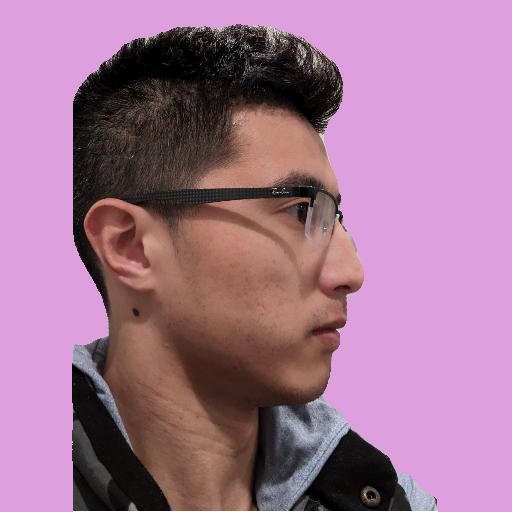

input_data/PXL_20230617_040635500.PORTRAIT.jpg


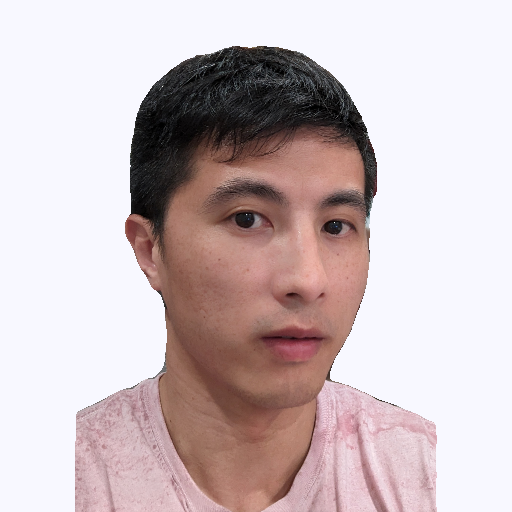

input_data/PXL_20230402_021142975.MP.jpg


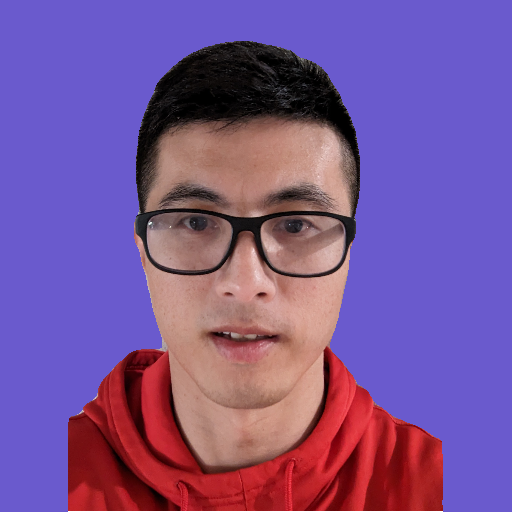

input_data/PXL_20230402_021527720.jpg


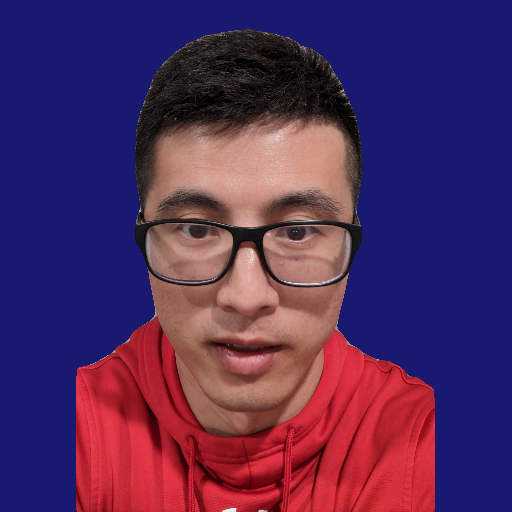

input_data/PXL_20230402_021602761.MP.jpg


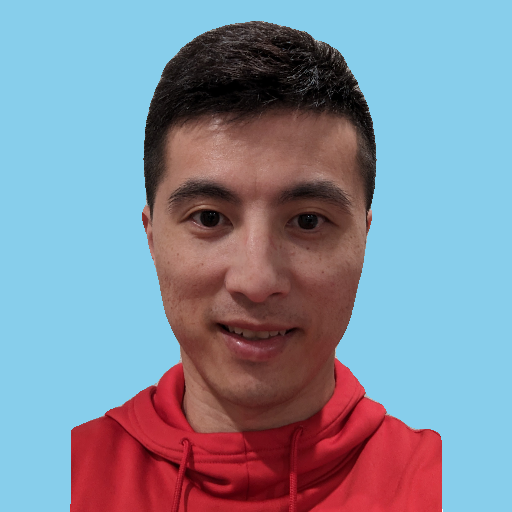

input_data/PXL_20230408_013650456.jpg


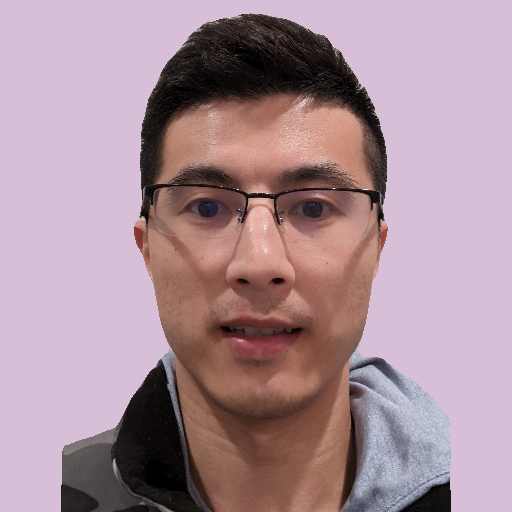

input_data/PXL_20230408_013702509.MP.jpg


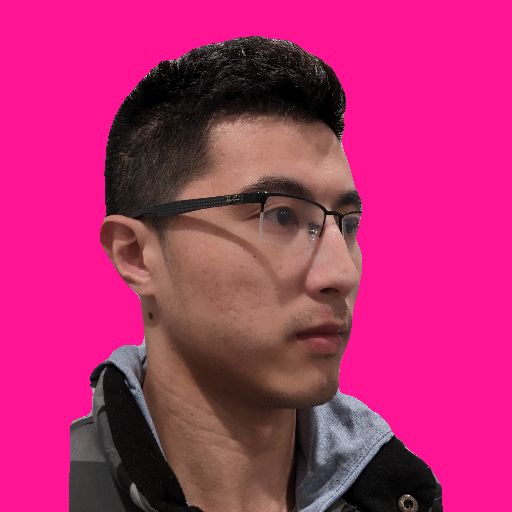

input_data/PXL_20230617_040625790.PORTRAIT.jpg


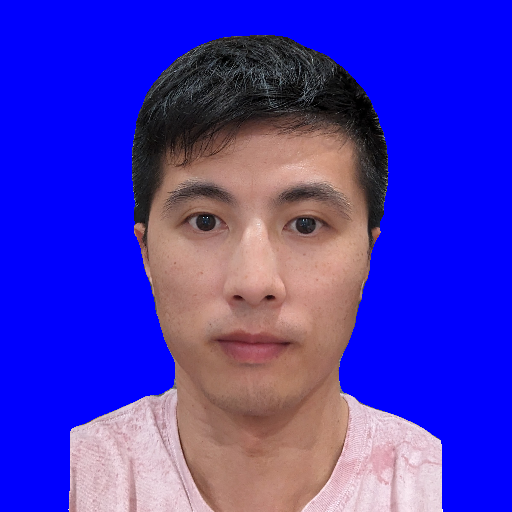

input_data/PXL_20230617_040644762.PORTRAIT.jpg


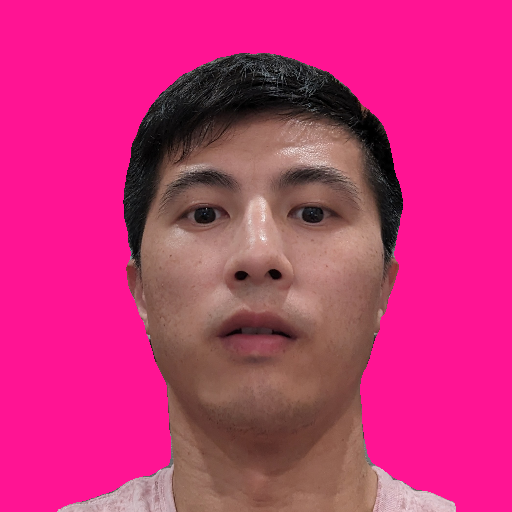

input_data/PXL_20230402_021539103.jpg


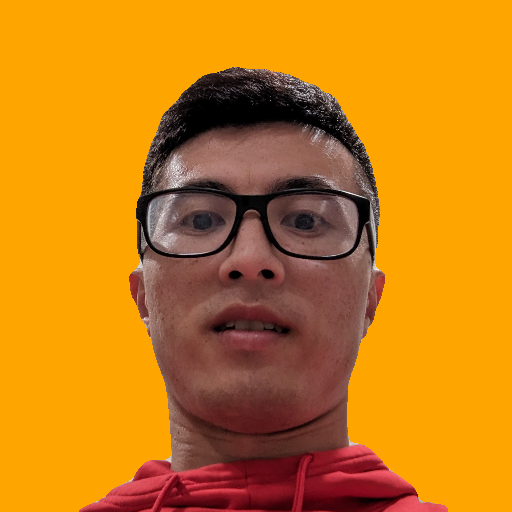

input_data/PXL_20230617_040658680.PORTRAIT.jpg


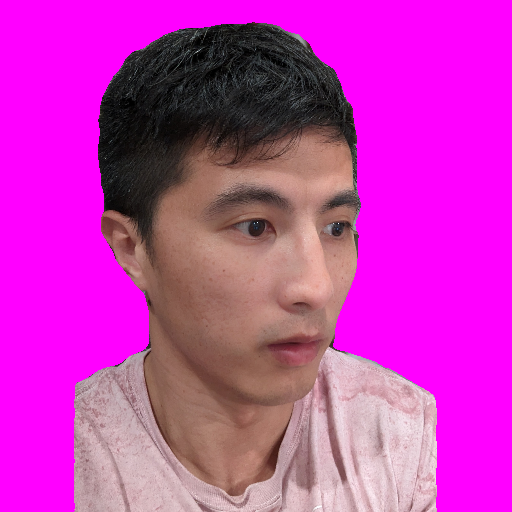

input_data/PXL_20230408_013800662.jpg


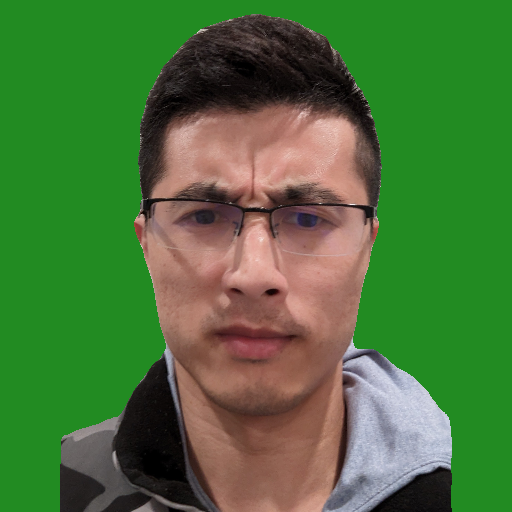

input_data/PXL_20230408_013744028.jpg


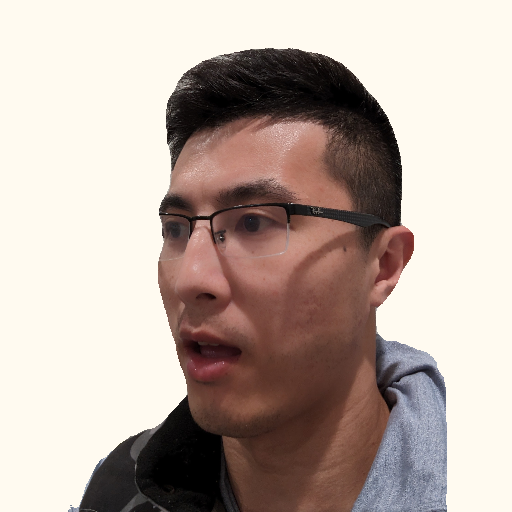

input_data/PXL_20230617_040642439.PORTRAIT.jpg


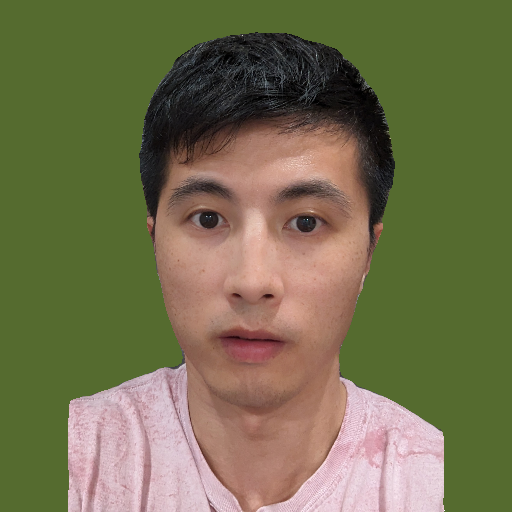

input_data/PXL_20230408_013659554.MP.jpg


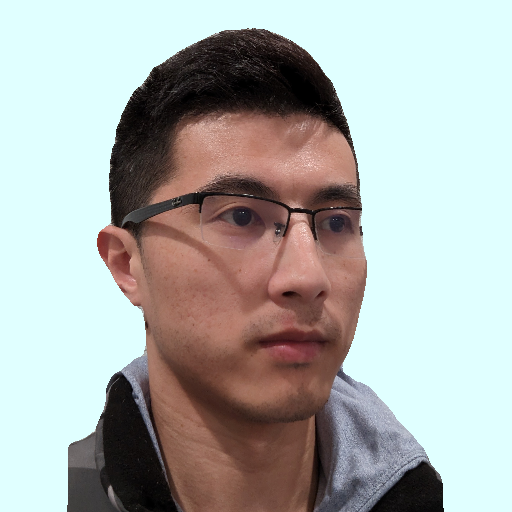

input_data/PXL_20230617_040631482.PORTRAIT.jpg


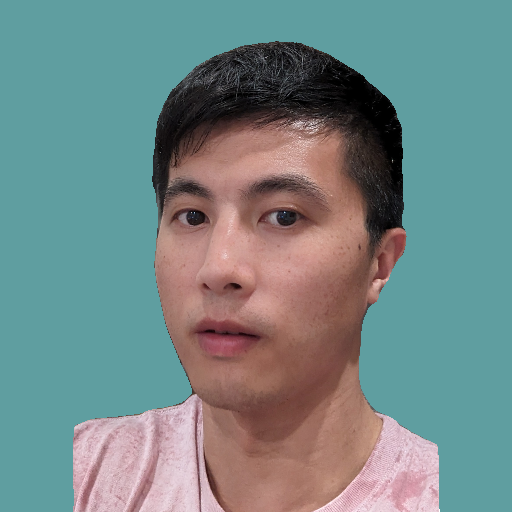

input_data/PXL_20230402_021506160.jpg


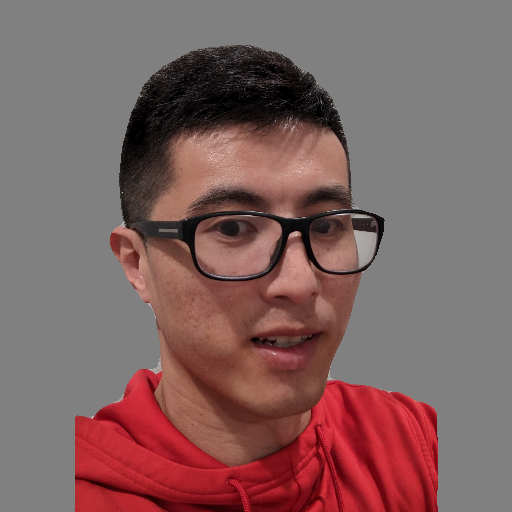

input_data/PXL_20230617_040649168.PORTRAIT.jpg


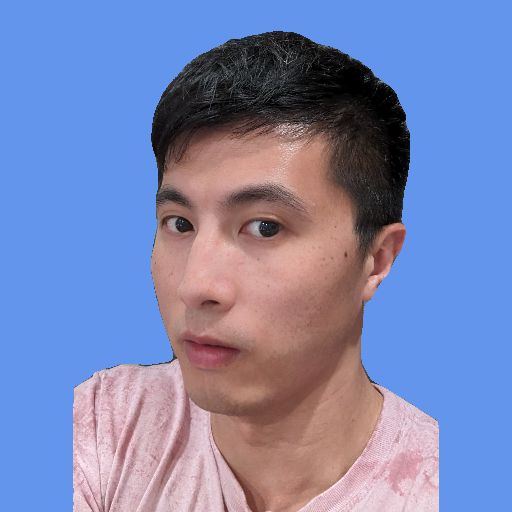

In [50]:
 # get the path/directory
folder_dir = 'input_data'
 
# iterate over files in
# that directory
for i, images in enumerate(glob.iglob(f'{folder_dir}/*')):
    print(images)
    # check if the image ends with png
    if (images.endswith(".jpg")):

        cropped_image = crop_largest_face(images, device)
        
        # generate a background
        background = Image.new(mode="RGBA", size=cropped_image.shape[:2], color=rnd.choice(colors))

        
        final_image = replace_background(cropped_image, background)
        
        display(final_image)
        final_image.save(f"data/image_{i}.jpg")
        

In [5]:
img = Image.open('test.jpg')

# face detection
mtcnn = MTCNN(
    image_size=160, margin=0, min_face_size=20,
    thresholds=[0.6, 0.7, 0.7], factor=0.709, post_process=True,
    device=device
)
boxes, _ = mtcnn.detect(img)

image_array = np.array(img)

### Get Largest Face

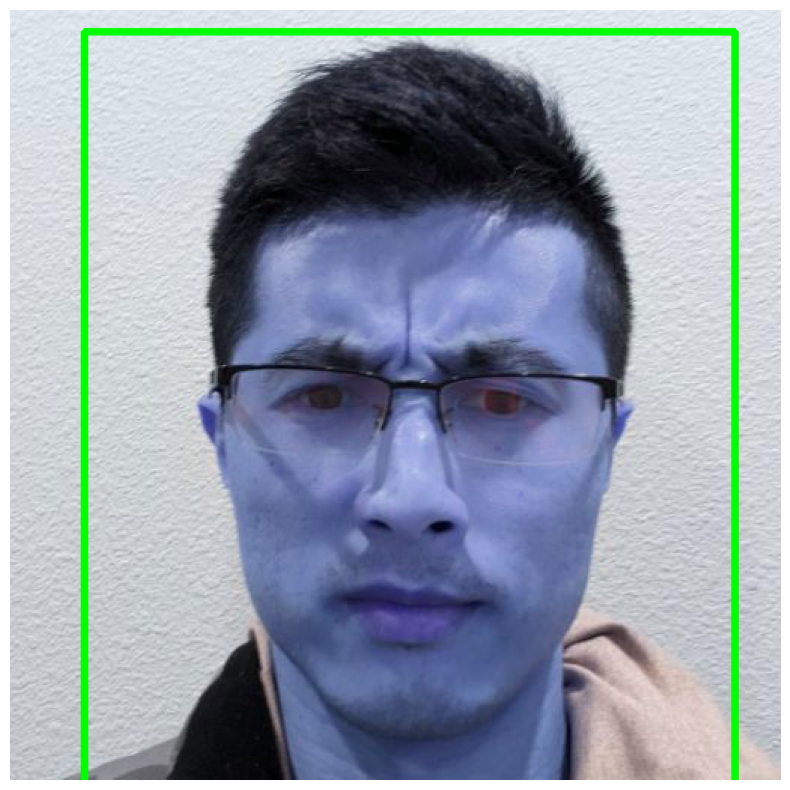

In [6]:
largest_index = 0
largest_face = 0

width = 0
height = 0

# find largest face
for i, (x1, y1, x2, y2) in enumerate(boxes):
    
    w = x2-x1
    h = y2-y1
    
    area = w*h
    
    if area > largest_face:
        largest_face = area
        largest_index = i
        width = w
        height = h

        

a, b, c, d = boxes[largest_index]

x1 = int(a-width/3)
y1 = int(b-height/3)

x2 = int(c+width/3)
y2 = int(d+height/3)

cv2.rectangle(image_array, (x1, y1), (x2, y2), (0, 255, 0), 4)

import matplotlib.pyplot as plt

img_rgb = cv2.cvtColor(image_array, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(20,10))
plt.imshow(img_rgb)
plt.axis('off')
plt.show()

### Crop and Pad Image

In [7]:
from typing import Tuple

def resize_with_pad(image: np.array, 
                    new_shape: Tuple[int, int], 
                    padding_color: Tuple[int] = (255, 255, 255)) -> np.array:
    """Maintains aspect ratio and resizes with padding.
    Params:
        image: Image to be resized.
        new_shape: Expected (width, height) of new image.
        padding_color: Tuple in BGR of padding color
    Returns:
        image: Resized image with padding
    """
    original_shape = (image.shape[1], image.shape[0])
    ratio = float(max(new_shape))/max(original_shape)
    new_size = tuple([int(x*ratio) for x in original_shape])
    image = cv2.resize(image, new_size)
    delta_w = new_shape[0] - new_size[0]
    delta_h = new_shape[1] - new_size[1]
    top, bottom = delta_h//2, delta_h-(delta_h//2)
    left, right = delta_w//2, delta_w-(delta_w//2)
    image = cv2.copyMakeBorder(image, top, bottom, left, right, cv2.BORDER_CONSTANT, value=padding_color)
    return image

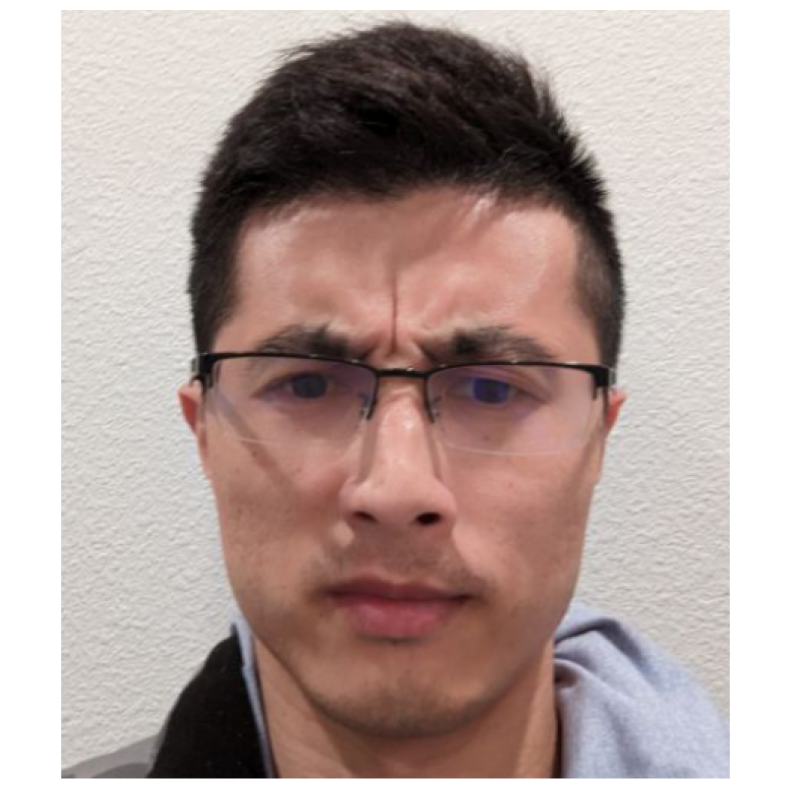

In [8]:
MAX_SIZE = 512

crop_img = np.array(img)[y1:y2, x1:x2]

crop_img = resize_with_pad(crop_img,(MAX_SIZE,MAX_SIZE))

plt.figure(figsize=(20,10))
plt.imshow(crop_img)
plt.axis('off')
plt.show()

### Segement Faces

In [9]:
!pip install -U people_segmentation --quiet

In [10]:
from people_segmentation.pre_trained_models import create_model

model = create_model("Unet_2020-07-20")
model.eval()

/opt/conda/lib/python3.10/site-packages/torch/hub.py:665: UserWarning: Falling back to the old format < 1.6. This support will be deprecated in favor of default zipfile format introduced in 1.6. Please redo torch.save() to save it in the new zipfile format.
  warnings.warn('Falling back to the old format < 1.6. This support will be '


Unet(
  (encoder): EfficientNetEncoder(
    (conv_stem): Conv2d(3, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): Swish()
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=40, bias=False)
          (bn1): BatchNormAct2d(
            40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): Swish()
          )
          (se): SqueezeExcite(
            (conv_reduce): Conv2d(40, 10, kernel_size=(1, 1), stride=(1, 1))
            (act1): Swish()
            (conv_expand): Conv2d(10, 40, kernel_size=(1, 1), stride=(1, 1))
            (gate): Sigmoid()
          )
          (conv_pw): Conv2d(40, 24, kernel_size=(1, 1), stride=(1, 1), bias=False

In [11]:
from iglovikov_helper_functions.dl.pytorch.utils import tensor_from_rgb_image
from iglovikov_helper_functions.utils.image_utils import pad, unpad
import albumentations as albu
import cv2
import torch

transform = albu.Compose(
    [albu.LongestMaxSize(max_size=MAX_SIZE), albu.Normalize(p=1)], p=1
)

In [12]:
from PIL import Image, ImageOps
import numpy as np

# uploaded_file = 'test2.jpg'
# pil_image = Image.open(uploaded_file)
original_image = crop_img

original_height, original_width = original_image.shape[:2]
image = transform(image=original_image)["image"]
padded_image, pads = pad(image, factor=MAX_SIZE, border=cv2.BORDER_CONSTANT)

x = torch.unsqueeze(tensor_from_rgb_image(padded_image), 0)

In [13]:
with torch.no_grad():
    prediction = model(x)[0][0]

In [14]:
mask = (prediction > 0).cpu().numpy().astype(np.uint8)
mask = unpad(mask, pads)
mask = cv2.resize(
    mask, (original_width, original_height), interpolation=cv2.INTER_NEAREST
)
mask_3_channels = cv2.cvtColor(mask, cv2.COLOR_GRAY2RGB)
dst = cv2.addWeighted(
    original_image, 1, (mask_3_channels * (0, 255, 0)).astype(np.uint8), 0.5, 0
)

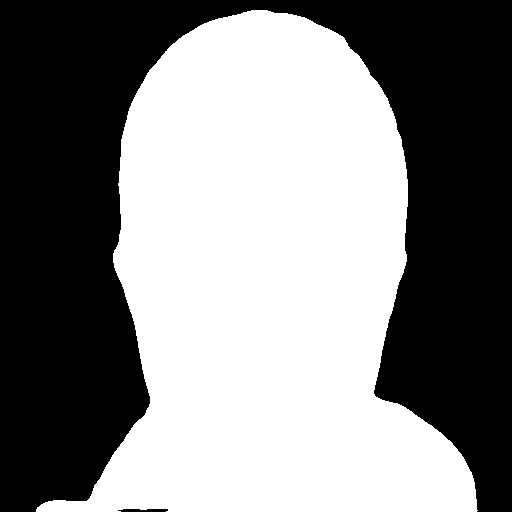

In [15]:
invert_mask = Image.fromarray(mask*255).convert('L')
invert_mask

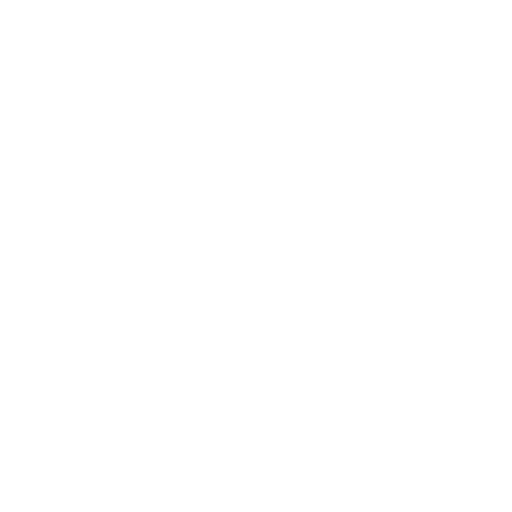

In [16]:
background = Image.new(mode="RGBA", size=(original_height, original_width), color="white")

background

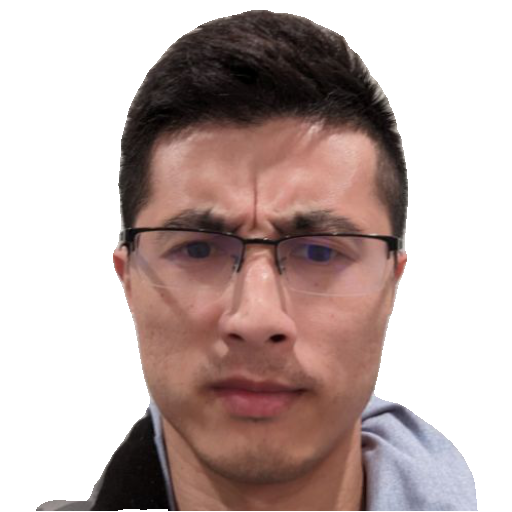

In [17]:
pil_image = Image.fromarray(original_image)

final = Image.composite(pil_image, background, invert_mask)
final